In [1]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

0

In [3]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Sep 14 16:21:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 15%   51C    P2              60W / 250W |    386MiB / 11264MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [5]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1,wrapper_kwargs={"clip_reward":False})
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(1154, 4, 84, 84) (1154,) (1154,) (1154,) (1154,) (1154, 4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(1, 4, 84, 84)


In [6]:
mean=observations.mean(axis=0)
std=observations.std(axis=0)
print(mean.shape, std.shape)
print(mean, std)

(4, 84, 84) (4, 84, 84)
[[[ 87.31369151  87.31369151  66.47746967 ...  66.47746967  87.31369151
    87.31369151]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]

 [[ 87.54246101  87.54246101  66.65164645 ...  66.65164645  87.54246101
    87.54246101]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.   

In [7]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)

prev = PolicyNetwork(env.action_space.n).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

# optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-5)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean()
std=observations.std()
print(mean.shape, std.shape)

Normlization=True
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
    with torch.no_grad():
        prev_dist = Categorical(logits=prev(obs_batch))
        reference_chosen_logps = prev_dist.log_prob(act_batch)
        reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
    ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios-ref_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 1
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    if epoch <5000:
        losses=-policy_chosen_logps

    else:
        losses = (-F.logsigmoid(beta * logits))
    # losses = -policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})
    if epoch==5000:
        prev.load_state_dict(policy_network.state_dict())
    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
            if not saved_frame:
                saved_frame = True
                image_path = f"test_{epoch}.gif"
                imageio.mimsave("./gif/"+image_path, frames, duration=40)
        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


() ()


  0%|          | 69/100000 [00:02<44:56, 37.06it/s]  

  0%|          | 497/100000 [00:13<44:20, 37.40it/s]/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
  1%|          | 505/100000 [00:18<6:26:33,  4.29it/s]

Epoch [500/100000] loss: 0.19194699823856354 positive_reward: -0.19194699823856354 negative_reward: -0.44687190651893616 margin: 0.2549249082803726 test_score: [1300.]


  1%|          | 1005/100000 [00:33<4:21:05,  6.32it/s]

Epoch [1000/100000] loss: 0.04714852198958397 positive_reward: -0.04714852198958397 negative_reward: -0.15203730762004852 margin: 0.10488878563046455 test_score: [430.]


  2%|▏         | 1505/100000 [00:50<5:05:32,  5.37it/s]

Epoch [1500/100000] loss: 0.019471969455480576 positive_reward: -0.019471969455480576 negative_reward: -0.07029613107442856 margin: 0.05082416161894798 test_score: [460.]


  2%|▏         | 2005/100000 [01:07<6:15:37,  4.35it/s]

Epoch [2000/100000] loss: 0.010035774670541286 positive_reward: -0.010035774670541286 negative_reward: -0.04074838012456894 margin: 0.030712605454027653 test_score: [640.]


  3%|▎         | 2505/100000 [01:25<7:07:35,  3.80it/s]

Epoch [2500/100000] loss: 0.00542644876986742 positive_reward: -0.00542644876986742 negative_reward: -0.035175956785678864 margin: 0.029749508015811443 test_score: [2060.]


  3%|▎         | 3005/100000 [01:42<5:31:51,  4.87it/s]

Epoch [3000/100000] loss: 0.0029279422014951706 positive_reward: -0.0029279422014951706 negative_reward: -0.015262164175510406 margin: 0.012334221974015236 test_score: [450.]


  4%|▎         | 3505/100000 [02:01<8:55:44,  3.00it/s] 

Epoch [3500/100000] loss: 0.0016724059823900461 positive_reward: -0.0016724059823900461 negative_reward: -0.006350708194077015 margin: 0.004678302211686969 test_score: [3240.]


  4%|▍         | 4005/100000 [02:18<5:32:12,  4.82it/s]

Epoch [4000/100000] loss: 0.0010081337532028556 positive_reward: -0.0010081337532028556 negative_reward: -0.005790557712316513 margin: 0.0047824239591136575 test_score: [1160.]


  5%|▍         | 4505/100000 [02:34<3:26:32,  7.71it/s]

Epoch [4500/100000] loss: 0.0006392840878106654 positive_reward: -0.0006392840878106654 negative_reward: -0.0082510681822896 margin: 0.007611784094478935 test_score: [340.]


  5%|▌         | 5005/100000 [02:53<9:10:08,  2.88it/s] 

Epoch [5000/100000] loss: 0.6931471824645996 positive_reward: -0.0004212686908431351 negative_reward: -0.0004212686908431351 margin: 0.0 test_score: [3240.]


  6%|▌         | 5505/100000 [03:09<3:49:39,  6.86it/s]

Epoch [5500/100000] loss: 0.6939859986305237 positive_reward: -0.0010485772509127855 negative_reward: -0.006266907788813114 margin: 0.005218330537900329 test_score: [320.]


  6%|▌         | 6005/100000 [03:25<4:15:36,  6.13it/s]

Epoch [6000/100000] loss: 0.6931469440460205 positive_reward: -0.0008452454931102693 negative_reward: -0.00742142740637064 margin: 0.0065761819132603705 test_score: [480.]


  7%|▋         | 6505/100000 [03:41<3:28:26,  7.48it/s]

Epoch [6500/100000] loss: 0.6938914656639099 positive_reward: -0.0006441946025006473 negative_reward: -0.00800658855587244 margin: 0.007362393953371793 test_score: [310.]


  7%|▋         | 7005/100000 [03:57<5:15:41,  4.91it/s]

Epoch [7000/100000] loss: 0.6941062808036804 positive_reward: -0.0006716569769196212 negative_reward: -0.004945666994899511 margin: 0.00427401001797989 test_score: [1010.]


  8%|▊         | 7505/100000 [04:17<8:29:54,  3.02it/s] 

Epoch [7500/100000] loss: 0.6945034265518188 positive_reward: -0.0010012183338403702 negative_reward: -0.008669237606227398 margin: 0.007668019272387028 test_score: [3240.]


  8%|▊         | 8005/100000 [04:33<4:45:21,  5.37it/s]

Epoch [8000/100000] loss: 0.6931471824645996 positive_reward: -0.0007697779801674187 negative_reward: -0.0007697779801674187 margin: 0.0 test_score: [1080.]


  9%|▊         | 8505/100000 [04:52<8:15:30,  3.08it/s] 

Epoch [8500/100000] loss: 0.6931471824645996 positive_reward: -0.0006607161485590041 negative_reward: -0.0006607161485590041 margin: 0.0 test_score: [3240.]


  9%|▉         | 9005/100000 [05:12<8:31:41,  2.96it/s] 

Epoch [9000/100000] loss: 0.6948621273040771 positive_reward: -0.001008725492283702 negative_reward: -0.003173322416841984 margin: 0.002164596924558282 test_score: [3240.]


 10%|▉         | 9505/100000 [05:30<7:26:54,  3.37it/s] 

Epoch [9500/100000] loss: 0.6937469244003296 positive_reward: -0.0008514848886989057 negative_reward: -0.007214878220111132 margin: 0.006363393331412226 test_score: [2260.]


 10%|█         | 10005/100000 [05:46<3:49:04,  6.55it/s]

Epoch [10000/100000] loss: 6.863010883331299 positive_reward: -2.2046122550964355 negative_reward: -0.16087667644023895 margin: -2.0437355786561966 test_score: [220.]


 11%|█         | 10505/100000 [06:02<3:16:23,  7.60it/s]

Epoch [10500/100000] loss: 0.6940943598747253 positive_reward: -0.0006694095209240913 negative_reward: -0.012485863640904427 margin: 0.011816454119980335 test_score: [240.]


 11%|█         | 11005/100000 [06:21<8:19:25,  2.97it/s] 

Epoch [11000/100000] loss: 0.6931471824645996 positive_reward: -0.0005345650133676827 negative_reward: -0.0005345650133676827 margin: 0.0 test_score: [3240.]


 12%|█▏        | 11505/100000 [06:40<7:04:21,  3.48it/s]

Epoch [11500/100000] loss: 0.6931471824645996 positive_reward: -0.000519721070304513 negative_reward: -0.000519721070304513 margin: 0.0 test_score: [3190.]


 12%|█▏        | 12005/100000 [06:59<7:54:21,  3.09it/s] 

Epoch [12000/100000] loss: 0.6931471824645996 positive_reward: -0.0006937600555829704 negative_reward: -0.0006937600555829704 margin: 0.0 test_score: [3240.]


 13%|█▎        | 12505/100000 [07:15<4:35:31,  5.29it/s]

Epoch [12500/100000] loss: 0.6931471824645996 positive_reward: -0.0003911163948941976 negative_reward: -0.0003911163948941976 margin: 0.0 test_score: [1190.]


 13%|█▎        | 13005/100000 [07:32<4:37:47,  5.22it/s]

Epoch [13000/100000] loss: 0.6931471824645996 positive_reward: -0.0004600106622092426 negative_reward: -0.0004600106622092426 margin: 0.0 test_score: [1110.]


 14%|█▎        | 13505/100000 [07:51<8:03:07,  2.98it/s] 

Epoch [13500/100000] loss: 0.6931471824645996 positive_reward: -0.0005086844321340322 negative_reward: -0.0005086844321340322 margin: 0.0 test_score: [3240.]


 14%|█▍        | 14005/100000 [08:10<7:44:11,  3.09it/s] 

Epoch [14000/100000] loss: 0.6931471824645996 positive_reward: -0.0005253299023024738 negative_reward: -0.0005253299023024738 margin: 0.0 test_score: [3240.]


 15%|█▍        | 14505/100000 [08:26<3:21:55,  7.06it/s]

Epoch [14500/100000] loss: 0.6928370594978333 positive_reward: -0.0005823272513225675 negative_reward: -0.008028339594602585 margin: 0.007446012343280017 test_score: [330.]


 15%|█▌        | 15005/100000 [08:42<3:49:26,  6.17it/s]

Epoch [15000/100000] loss: 0.6963253617286682 positive_reward: -0.0010465906234458089 negative_reward: -0.00845271721482277 margin: 0.00740612659137696 test_score: [360.]


 16%|█▌        | 15505/100000 [08:59<5:10:58,  4.53it/s]

Epoch [15500/100000] loss: 0.6931471824645996 positive_reward: -0.0007899348856881261 negative_reward: -0.0007899348856881261 margin: 0.0 test_score: [690.]


 16%|█▌        | 16005/100000 [09:19<7:56:10,  2.94it/s] 

Epoch [16000/100000] loss: 0.6953298449516296 positive_reward: -0.00043321523116901517 negative_reward: -0.004554213955998421 margin: 0.0041209987248294055 test_score: [3240.]


 17%|█▋        | 16505/100000 [09:36<4:33:24,  5.09it/s]

Epoch [16500/100000] loss: 0.6969510316848755 positive_reward: -0.0008191235829144716 negative_reward: -0.005950216203927994 margin: 0.005131092621013522 test_score: [1160.]


 17%|█▋        | 17005/100000 [09:54<7:07:46,  3.23it/s]

Epoch [17000/100000] loss: 0.6931471824645996 positive_reward: -0.0007389322854578495 negative_reward: -0.0007389322854578495 margin: 0.0 test_score: [1240.]


 18%|█▊        | 17505/100000 [10:11<3:42:02,  6.19it/s]

Epoch [17500/100000] loss: 0.6930201649665833 positive_reward: -0.0005509634502232075 negative_reward: -0.008141101337969303 margin: 0.007590137887746096 test_score: [320.]


 18%|█▊        | 18005/100000 [10:30<7:35:04,  3.00it/s] 

Epoch [18000/100000] loss: 0.698797345161438 positive_reward: -0.0033202683553099632 negative_reward: -0.008282256312668324 margin: 0.00496198795735836 test_score: [3240.]


 19%|█▊        | 18505/100000 [10:47<4:39:50,  4.85it/s]

Epoch [18500/100000] loss: 0.6931471824645996 positive_reward: -0.0003181569918524474 negative_reward: -0.0003181569918524474 margin: 0.0 test_score: [1560.]


 19%|█▉        | 19005/100000 [11:03<4:16:13,  5.27it/s]

Epoch [19000/100000] loss: 0.6931471824645996 positive_reward: -0.0008918813546188176 negative_reward: -0.0008918813546188176 margin: 0.0 test_score: [410.]


 20%|█▉        | 19505/100000 [11:20<4:09:21,  5.38it/s]

Epoch [19500/100000] loss: 0.6936593651771545 positive_reward: -0.0004971816670149565 negative_reward: -0.004002900794148445 margin: 0.0035057191271334887 test_score: [1140.]


 20%|██        | 20005/100000 [11:35<2:47:02,  7.98it/s]

Epoch [20000/100000] loss: 0.6931471824645996 positive_reward: -0.0011763201327994466 negative_reward: -0.0011763201327994466 margin: 0.0 test_score: [320.]


 21%|██        | 20505/100000 [11:51<3:37:01,  6.10it/s]

Epoch [20500/100000] loss: 0.6931471824645996 positive_reward: -0.00028193637263029814 negative_reward: -0.00028193637263029814 margin: 0.0 test_score: [330.]


 21%|██        | 21005/100000 [12:11<7:33:47,  2.90it/s] 

Epoch [21000/100000] loss: 0.6931471824645996 positive_reward: -0.00024386707809753716 negative_reward: -0.00024386707809753716 margin: 0.0 test_score: [3240.]


 22%|██▏       | 21505/100000 [12:30<7:11:20,  3.03it/s] 

Epoch [21500/100000] loss: 0.6931471824645996 positive_reward: -0.00020460858650039881 negative_reward: -0.00020460858650039881 margin: 0.0 test_score: [3240.]


 22%|██▏       | 22005/100000 [12:46<2:58:41,  7.27it/s]

Epoch [22000/100000] loss: 0.6931471824645996 positive_reward: -0.00018206585082225502 negative_reward: -0.00018206585082225502 margin: 0.0 test_score: [300.]


 23%|██▎       | 22505/100000 [13:02<3:41:19,  5.84it/s]

Epoch [22500/100000] loss: 0.6931471824645996 positive_reward: -0.00016651864279992878 negative_reward: -0.00016651864279992878 margin: 0.0 test_score: [1980.]


 23%|██▎       | 23005/100000 [13:18<3:56:01,  5.44it/s]

Epoch [23000/100000] loss: 0.6928505897521973 positive_reward: -0.00015710834122728556 negative_reward: -0.007847226224839687 margin: 0.007690117883612402 test_score: [1900.]


 24%|██▎       | 23505/100000 [13:35<3:41:31,  5.76it/s]

Epoch [23500/100000] loss: 0.6931471824645996 positive_reward: -0.00014711706899106503 negative_reward: -0.00014711706899106503 margin: 0.0 test_score: [740.]


 24%|██▍       | 24005/100000 [13:52<4:53:20,  4.32it/s]

Epoch [24000/100000] loss: 0.6931471824645996 positive_reward: -0.0001855946029536426 negative_reward: -0.0001855946029536426 margin: 0.0 test_score: [710.]


 25%|██▍       | 24505/100000 [14:09<3:49:55,  5.47it/s]

Epoch [24500/100000] loss: 0.6931471824645996 positive_reward: -0.0003839638375211507 negative_reward: -0.0003839638375211507 margin: 0.0 test_score: [1970.]


 25%|██▌       | 25005/100000 [14:28<6:52:01,  3.03it/s]

Epoch [25000/100000] loss: 0.6933533549308777 positive_reward: -0.0002772142761386931 negative_reward: -0.006255052983760834 margin: 0.005977838707622141 test_score: [3240.]


 26%|██▌       | 25505/100000 [14:44<3:37:36,  5.71it/s]

Epoch [25500/100000] loss: 0.6931471824645996 positive_reward: -0.0009060616721399128 negative_reward: -0.0009060616721399128 margin: 0.0 test_score: [840.]


 26%|██▌       | 26005/100000 [15:00<3:16:12,  6.29it/s]

Epoch [26000/100000] loss: 0.6931471824645996 positive_reward: -0.00021078019926790148 negative_reward: -0.00021078019926790148 margin: 0.0 test_score: [210.]


 27%|██▋       | 26505/100000 [15:17<3:56:17,  5.18it/s]

Epoch [26500/100000] loss: 0.6931471824645996 positive_reward: -0.00019412065739743412 negative_reward: -0.00019412065739743412 margin: 0.0 test_score: [510.]


 27%|██▋       | 27005/100000 [15:36<6:40:15,  3.04it/s]

Epoch [27000/100000] loss: 0.6931471824645996 positive_reward: -0.0002839602530002594 negative_reward: -0.0002839602530002594 margin: 0.0 test_score: [3240.]


 28%|██▊       | 27505/100000 [15:54<4:43:18,  4.26it/s]

Epoch [27500/100000] loss: 0.6931471824645996 positive_reward: -0.00029558531241491437 negative_reward: -0.00029558531241491437 margin: 0.0 test_score: [1950.]


 28%|██▊       | 28005/100000 [16:09<3:02:12,  6.59it/s]

Epoch [28000/100000] loss: 0.6949583292007446 positive_reward: -0.000425917241955176 negative_reward: -0.0022270658519119024 margin: 0.0018011486099567264 test_score: [340.]


 29%|██▊       | 28505/100000 [16:26<3:31:31,  5.63it/s]

Epoch [28500/100000] loss: 0.6930702328681946 positive_reward: -0.00020464661065489054 negative_reward: -0.004660621285438538 margin: 0.004455974674783647 test_score: [1190.]


 29%|██▉       | 29005/100000 [16:43<4:24:23,  4.48it/s]

Epoch [29000/100000] loss: 0.6931471824645996 positive_reward: -0.0003365131560713053 negative_reward: -0.0003365131560713053 margin: 0.0 test_score: [1590.]


 30%|██▉       | 29505/100000 [17:02<6:34:04,  2.98it/s]

Epoch [29500/100000] loss: 0.6989476084709167 positive_reward: -0.0010900171473622322 negative_reward: -0.007382928393781185 margin: 0.006292911246418953 test_score: [3240.]


 30%|███       | 30005/100000 [17:19<3:35:13,  5.42it/s]

Epoch [30000/100000] loss: 0.6931471824645996 positive_reward: -0.00030487580806948245 negative_reward: -0.00030487580806948245 margin: 0.0 test_score: [1090.]


 31%|███       | 30505/100000 [17:38<6:39:47,  2.90it/s]

Epoch [30500/100000] loss: 0.6931471824645996 positive_reward: -0.00017796603788156062 negative_reward: -0.00017796603788156062 margin: 0.0 test_score: [3240.]


 31%|███       | 31005/100000 [17:55<3:21:20,  5.71it/s]

Epoch [31000/100000] loss: 0.6941766738891602 positive_reward: -0.0007377174915745854 negative_reward: -0.00718326773494482 margin: 0.006445550243370235 test_score: [1140.]


 32%|███▏      | 31505/100000 [18:13<4:49:33,  3.94it/s]

Epoch [31500/100000] loss: 0.6937397718429565 positive_reward: -0.00042972201481461525 negative_reward: -0.005952348001301289 margin: 0.005522625986486673 test_score: [2350.]


 32%|███▏      | 32005/100000 [18:28<2:29:26,  7.58it/s]

Epoch [32000/100000] loss: 0.6931471824645996 positive_reward: -7.655591616639867e-05 negative_reward: -7.655591616639867e-05 margin: 0.0 test_score: [370.]


 33%|███▎      | 32505/100000 [18:45<3:42:16,  5.06it/s]

Epoch [32500/100000] loss: 0.6931471824645996 positive_reward: -0.00015755790809635073 negative_reward: -0.00015755790809635073 margin: 0.0 test_score: [1000.]


 33%|███▎      | 33005/100000 [19:01<3:35:19,  5.19it/s]

Epoch [33000/100000] loss: 0.6931471824645996 positive_reward: -9.667811536928639e-05 negative_reward: -9.667811536928639e-05 margin: 0.0 test_score: [570.]


 34%|███▎      | 33505/100000 [19:19<4:19:48,  4.27it/s]

Epoch [33500/100000] loss: 0.6931471824645996 positive_reward: -8.75041660037823e-05 negative_reward: -8.75041660037823e-05 margin: 0.0 test_score: [770.]


 34%|███▍      | 34005/100000 [19:38<6:01:38,  3.04it/s]

Epoch [34000/100000] loss: 0.6931471824645996 positive_reward: -0.00011692509724525735 negative_reward: -0.00011692509724525735 margin: 0.0 test_score: [3240.]


 35%|███▍      | 34505/100000 [19:57<6:02:16,  3.01it/s]

Epoch [34500/100000] loss: 0.6931471824645996 positive_reward: -6.890420627314597e-05 negative_reward: -6.890420627314597e-05 margin: 0.0 test_score: [3240.]


 35%|███▌      | 35005/100000 [20:17<5:55:26,  3.05it/s]

Epoch [35000/100000] loss: 0.6943637132644653 positive_reward: -0.00026173153310082853 negative_reward: -0.0032318956218659878 margin: 0.0029701640887651592 test_score: [3240.]


 36%|███▌      | 35505/100000 [20:36<5:52:58,  3.05it/s]

Epoch [35500/100000] loss: 0.6931471824645996 positive_reward: -0.0002021574618993327 negative_reward: -0.0002021574618993327 margin: 0.0 test_score: [3240.]


 36%|███▌      | 36005/100000 [20:52<3:20:06,  5.33it/s]

Epoch [36000/100000] loss: 0.6946271657943726 positive_reward: -0.00047928415006026626 negative_reward: -0.00325892586261034 margin: 0.002779641712550074 test_score: [890.]


 37%|███▋      | 36505/100000 [21:09<3:14:35,  5.44it/s]

Epoch [36500/100000] loss: 0.6931471824645996 positive_reward: -8.898673695512116e-05 negative_reward: -8.898673695512116e-05 margin: 0.0 test_score: [370.]


 37%|███▋      | 37005/100000 [21:26<3:19:15,  5.27it/s]

Epoch [37000/100000] loss: 0.6960718035697937 positive_reward: -0.0002662090118974447 negative_reward: -0.003934201784431934 margin: 0.0036679927725344896 test_score: [630.]


 38%|███▊      | 37505/100000 [21:43<4:11:02,  4.15it/s]

Epoch [37500/100000] loss: 0.6931471824645996 positive_reward: -0.00018403930880594999 negative_reward: -0.00018403930880594999 margin: 0.0 test_score: [980.]


 38%|███▊      | 38005/100000 [22:00<3:25:50,  5.02it/s]

Epoch [38000/100000] loss: 0.6931471824645996 positive_reward: -0.00019302070722915232 negative_reward: -0.00019302070722915232 margin: 0.0 test_score: [870.]


 39%|███▊      | 38505/100000 [22:17<3:32:04,  4.83it/s]

Epoch [38500/100000] loss: 0.6931471824645996 positive_reward: -0.0017814611783251166 negative_reward: -0.0017814611783251166 margin: 0.0 test_score: [730.]


 39%|███▉      | 39005/100000 [22:36<5:38:30,  3.00it/s]

Epoch [39000/100000] loss: 0.6931471824645996 positive_reward: -0.00015596128650940955 negative_reward: -0.00015596128650940955 margin: 0.0 test_score: [3240.]


 40%|███▉      | 39505/100000 [22:53<3:32:56,  4.73it/s]

Epoch [39500/100000] loss: 0.6926494836807251 positive_reward: -0.0002930366899818182 negative_reward: -0.008521371521055698 margin: 0.00822833483107388 test_score: [600.]


 40%|████      | 40005/100000 [23:09<2:49:12,  5.91it/s]

Epoch [40000/100000] loss: 0.6931471824645996 positive_reward: -0.00014205367187969387 negative_reward: -0.00014205367187969387 margin: 0.0 test_score: [1160.]


 41%|████      | 40505/100000 [23:26<3:10:48,  5.20it/s]

Epoch [40500/100000] loss: 0.6931471824645996 positive_reward: -0.00021395196381490678 negative_reward: -0.00021395196381490678 margin: 0.0 test_score: [720.]


 41%|████      | 41005/100000 [23:43<3:37:07,  4.53it/s]

Epoch [41000/100000] loss: 0.6931471824645996 positive_reward: -0.0001779726444510743 negative_reward: -0.0001779726444510743 margin: 0.0 test_score: [1300.]


 42%|████▏     | 41505/100000 [23:59<2:21:20,  6.90it/s]

Epoch [41500/100000] loss: 0.6957995295524597 positive_reward: -0.00029967768932692707 negative_reward: -0.006222309544682503 margin: 0.005922631855355576 test_score: [320.]


 42%|████▏     | 42005/100000 [24:15<2:47:19,  5.78it/s]

Epoch [42000/100000] loss: 0.6931471824645996 positive_reward: -3.931799074052833e-05 negative_reward: -3.931799074052833e-05 margin: 0.0 test_score: [440.]


 43%|████▎     | 42505/100000 [24:32<2:59:36,  5.34it/s]

Epoch [42500/100000] loss: 0.7291200757026672 positive_reward: -0.0075519271194934845 negative_reward: -0.03176375851035118 margin: 0.024211831390857697 test_score: [1070.]


 43%|████▎     | 43005/100000 [24:48<2:30:19,  6.32it/s]

Epoch [43000/100000] loss: 0.6931471824645996 positive_reward: -6.242104427656159e-05 negative_reward: -6.242104427656159e-05 margin: 0.0 test_score: [190.]


 44%|████▎     | 43505/100000 [25:04<2:54:51,  5.38it/s]

Epoch [43500/100000] loss: 0.6931471824645996 positive_reward: -7.747983909212053e-05 negative_reward: -7.747983909212053e-05 margin: 0.0 test_score: [1930.]


 44%|████▍     | 44005/100000 [25:20<2:04:54,  7.47it/s]

Epoch [44000/100000] loss: 0.6931471824645996 positive_reward: -0.00010347861825721338 negative_reward: -0.00010347861825721338 margin: 0.0 test_score: [340.]


 45%|████▍     | 44505/100000 [25:37<2:59:32,  5.15it/s]

Epoch [44500/100000] loss: 0.6931471824645996 positive_reward: -4.0316292142961174e-05 negative_reward: -4.0316292142961174e-05 margin: 0.0 test_score: [1140.]


 45%|████▌     | 45005/100000 [25:54<3:30:17,  4.36it/s]

Epoch [45000/100000] loss: 0.6931471824645996 positive_reward: -0.00011687882215483114 negative_reward: -0.00011687882215483114 margin: 0.0 test_score: [940.]


 46%|████▌     | 45505/100000 [26:10<2:44:45,  5.51it/s]

Epoch [45500/100000] loss: 0.6931471824645996 positive_reward: -0.000320935359923169 negative_reward: -0.000320935359923169 margin: 0.0 test_score: [400.]


 46%|████▌     | 46005/100000 [26:30<5:00:29,  2.99it/s]

Epoch [46000/100000] loss: 0.6926469802856445 positive_reward: -0.00026325872750021517 negative_reward: -0.01141402404755354 margin: 0.011150765320053324 test_score: [3240.]


 47%|████▋     | 46505/100000 [26:46<3:03:00,  4.87it/s]

Epoch [46500/100000] loss: 0.6931471824645996 positive_reward: -2.6502064429223537e-05 negative_reward: -2.6502064429223537e-05 margin: 0.0 test_score: [510.]


 47%|████▋     | 47005/100000 [27:03<2:47:06,  5.29it/s]

Epoch [47000/100000] loss: 0.6931471824645996 positive_reward: -0.0001448064431315288 negative_reward: -0.0001448064431315288 margin: 0.0 test_score: [1340.]


 48%|████▊     | 47505/100000 [27:18<1:51:21,  7.86it/s]

Epoch [47500/100000] loss: 0.6986858248710632 positive_reward: -0.0011731557315215468 negative_reward: -0.003492288524284959 margin: 0.002319132792763412 test_score: [240.]


 48%|████▊     | 48005/100000 [27:35<2:21:25,  6.13it/s]

Epoch [48000/100000] loss: 0.6931471824645996 positive_reward: -3.572807690943591e-05 negative_reward: -3.572807690943591e-05 margin: 0.0 test_score: [1120.]


 49%|████▊     | 48505/100000 [27:50<2:00:00,  7.15it/s]

Epoch [48500/100000] loss: 0.6931471824645996 positive_reward: -3.9524595194961876e-05 negative_reward: -3.9524595194961876e-05 margin: 0.0 test_score: [320.]


 49%|████▉     | 49005/100000 [28:07<2:43:51,  5.19it/s]

Epoch [49000/100000] loss: 0.6931471824645996 positive_reward: -6.906866474309936e-05 negative_reward: -6.906866474309936e-05 margin: 0.0 test_score: [330.]


 50%|████▉     | 49505/100000 [28:26<4:42:59,  2.97it/s]

Epoch [49500/100000] loss: 0.6931471824645996 positive_reward: -8.340353087987751e-05 negative_reward: -8.340353087987751e-05 margin: 0.0 test_score: [3240.]


 50%|█████     | 50005/100000 [28:46<4:42:07,  2.95it/s]

Epoch [50000/100000] loss: 0.6931471824645996 positive_reward: -5.105297896079719e-05 negative_reward: -5.105297896079719e-05 margin: 0.0 test_score: [3240.]


 51%|█████     | 50505/100000 [29:05<4:43:46,  2.91it/s]

Epoch [50500/100000] loss: 0.6931471824645996 positive_reward: -2.647148721734993e-05 negative_reward: -2.647148721734993e-05 margin: 0.0 test_score: [3240.]


 51%|█████     | 51005/100000 [29:21<2:12:47,  6.15it/s]

Epoch [51000/100000] loss: 0.6931471824645996 positive_reward: -0.0003789057955145836 negative_reward: -0.0003789057955145836 margin: 0.0 test_score: [300.]


 52%|█████▏    | 51505/100000 [29:41<4:23:49,  3.06it/s]

Epoch [51500/100000] loss: 0.6964117884635925 positive_reward: -0.0001455774763599038 negative_reward: -0.003596262773498893 margin: 0.003450685297138989 test_score: [3240.]


 52%|█████▏    | 52005/100000 [29:57<2:16:23,  5.86it/s]

Epoch [52000/100000] loss: 0.6931471824645996 positive_reward: -6.0888054576935247e-05 negative_reward: -6.0888054576935247e-05 margin: 0.0 test_score: [380.]


 53%|█████▎    | 52505/100000 [30:13<2:28:18,  5.34it/s]

Epoch [52500/100000] loss: 0.6926798820495605 positive_reward: -4.3212850869167596e-05 negative_reward: -0.007332065608352423 margin: 0.007288852757483255 test_score: [1160.]


 53%|█████▎    | 53005/100000 [30:30<2:18:59,  5.64it/s]

Epoch [53000/100000] loss: 0.6931471824645996 positive_reward: -0.00030814920319244266 negative_reward: -0.00030814920319244266 margin: 0.0 test_score: [1130.]


 54%|█████▎    | 53505/100000 [30:49<4:17:45,  3.01it/s]

Epoch [53500/100000] loss: 0.6931471824645996 positive_reward: -0.0003242434759158641 negative_reward: -0.0003242434759158641 margin: 0.0 test_score: [3240.]


 54%|█████▍    | 54005/100000 [31:08<4:12:57,  3.03it/s]

Epoch [54000/100000] loss: 0.6926130652427673 positive_reward: -4.04088495997712e-05 negative_reward: -0.010005639865994453 margin: 0.009965231016394682 test_score: [3240.]


 55%|█████▍    | 54505/100000 [31:25<2:39:26,  4.76it/s]

Epoch [54500/100000] loss: 0.6931471824645996 positive_reward: -8.914210047805682e-05 negative_reward: -8.914210047805682e-05 margin: 0.0 test_score: [640.]


 55%|█████▌    | 55005/100000 [31:41<1:43:59,  7.21it/s]

Epoch [55000/100000] loss: 0.6947894096374512 positive_reward: -0.0004820641770493239 negative_reward: -0.005062512122094631 margin: 0.004580447945045307 test_score: [270.]


 56%|█████▌    | 55505/100000 [32:00<4:04:38,  3.03it/s]

Epoch [55500/100000] loss: 0.6931471824645996 positive_reward: -0.0007012890418991446 negative_reward: -0.0007012890418991446 margin: 0.0 test_score: [3240.]


 56%|█████▌    | 56005/100000 [32:16<1:37:50,  7.49it/s]

Epoch [56000/100000] loss: 0.6931471824645996 positive_reward: -6.0455844504758716e-05 negative_reward: -6.0455844504758716e-05 margin: 0.0 test_score: [310.]


 57%|█████▋    | 56505/100000 [32:32<2:23:57,  5.04it/s]

Epoch [56500/100000] loss: 0.6931471824645996 positive_reward: -8.758102194406092e-05 negative_reward: -8.758102194406092e-05 margin: 0.0 test_score: [420.]


 57%|█████▋    | 57005/100000 [32:52<3:56:16,  3.03it/s]

Epoch [57000/100000] loss: 0.6931471824645996 positive_reward: -0.00011968199396505952 negative_reward: -0.00011968199396505952 margin: 0.0 test_score: [3240.]


 58%|█████▊    | 57505/100000 [33:08<1:49:57,  6.44it/s]

Epoch [57500/100000] loss: 0.6931471824645996 positive_reward: -2.8889555323985405e-05 negative_reward: -2.8889555323985405e-05 margin: 0.0 test_score: [290.]


 58%|█████▊    | 58005/100000 [33:27<3:49:50,  3.05it/s]

Epoch [58000/100000] loss: 0.6931471824645996 positive_reward: -0.00018406988237984478 negative_reward: -0.00018406988237984478 margin: 0.0 test_score: [3240.]


 59%|█████▊    | 58505/100000 [33:43<1:46:19,  6.50it/s]

Epoch [58500/100000] loss: 0.6931471824645996 positive_reward: -3.272739195381291e-05 negative_reward: -3.272739195381291e-05 margin: 0.0 test_score: [330.]


 59%|█████▉    | 59005/100000 [34:00<2:14:55,  5.06it/s]

Epoch [59000/100000] loss: 0.6931471824645996 positive_reward: -2.268240859848447e-05 negative_reward: -2.268240859848447e-05 margin: 0.0 test_score: [1460.]


 60%|█████▉    | 59505/100000 [34:16<1:51:27,  6.06it/s]

Epoch [59500/100000] loss: 0.6931471824645996 positive_reward: -1.687441545072943e-05 negative_reward: -1.687441545072943e-05 margin: 0.0 test_score: [390.]


 60%|██████    | 60005/100000 [34:33<2:18:25,  4.82it/s]

Epoch [60000/100000] loss: 0.6928398609161377 positive_reward: -0.000615131517406553 negative_reward: -0.004570686258375645 margin: 0.003955554740969092 test_score: [2040.]


 61%|██████    | 60505/100000 [34:50<2:22:08,  4.63it/s]

Epoch [60500/100000] loss: 0.6931471824645996 positive_reward: -3.28472196997609e-05 negative_reward: -3.28472196997609e-05 margin: 0.0 test_score: [890.]


 61%|██████    | 61005/100000 [35:06<1:58:39,  5.48it/s]

Epoch [61000/100000] loss: 0.6931471824645996 positive_reward: -0.0001366878132103011 negative_reward: -0.0001366878132103011 margin: 0.0 test_score: [930.]


 62%|██████▏   | 61505/100000 [35:23<1:54:45,  5.59it/s]

Epoch [61500/100000] loss: 0.6931471824645996 positive_reward: -6.547461816808209e-05 negative_reward: -6.547461816808209e-05 margin: 0.0 test_score: [1130.]


 62%|██████▏   | 62005/100000 [35:42<3:27:09,  3.06it/s]

Epoch [62000/100000] loss: 0.6950241923332214 positive_reward: -0.0004269675991963595 negative_reward: -0.001167970011010766 margin: 0.0007410024118144065 test_score: [3240.]


 63%|██████▎   | 62505/100000 [35:58<1:43:11,  6.06it/s]

Epoch [62500/100000] loss: 0.6931471824645996 positive_reward: -4.869110489380546e-05 negative_reward: -4.869110489380546e-05 margin: 0.0 test_score: [310.]


 63%|██████▎   | 63005/100000 [36:16<2:46:24,  3.71it/s]

Epoch [63000/100000] loss: 0.6931471824645996 positive_reward: -3.980144174420275e-05 negative_reward: -3.980144174420275e-05 margin: 0.0 test_score: [1420.]


 64%|██████▎   | 63505/100000 [36:32<1:29:12,  6.82it/s]

Epoch [63500/100000] loss: 0.6931471824645996 positive_reward: -9.926807251758873e-05 negative_reward: -9.926807251758873e-05 margin: 0.0 test_score: [370.]


 64%|██████▍   | 64005/100000 [36:49<2:10:03,  4.61it/s]

Epoch [64000/100000] loss: 0.6931471824645996 positive_reward: -3.223567910026759e-05 negative_reward: -3.223567910026759e-05 margin: 0.0 test_score: [1560.]


 65%|██████▍   | 64505/100000 [37:05<1:37:12,  6.09it/s]

Epoch [64500/100000] loss: 0.6931471824645996 positive_reward: -0.00012255705951247364 negative_reward: -0.00012255705951247364 margin: 0.0 test_score: [200.]


 65%|██████▌   | 65005/100000 [37:21<1:19:02,  7.38it/s]

Epoch [65000/100000] loss: 0.6930549144744873 positive_reward: -0.00048936961684376 negative_reward: -0.010086028836667538 margin: 0.009596659219823778 test_score: [330.]


 66%|██████▌   | 65505/100000 [37:37<1:44:25,  5.51it/s]

Epoch [65500/100000] loss: 0.6953484416007996 positive_reward: -0.0006799449911341071 negative_reward: -0.0026994049549102783 margin: 0.002019459963776171 test_score: [1150.]


 66%|██████▌   | 66005/100000 [37:53<1:14:54,  7.56it/s]

Epoch [66000/100000] loss: 0.6931471824645996 positive_reward: -1.7146303434856236e-05 negative_reward: -1.7146303434856236e-05 margin: 0.0 test_score: [340.]


 67%|██████▋   | 66505/100000 [38:12<3:05:20,  3.01it/s]

Epoch [66500/100000] loss: 0.6931471824645996 positive_reward: -1.924455318658147e-05 negative_reward: -1.924455318658147e-05 margin: 0.0 test_score: [3240.]


 67%|██████▋   | 67005/100000 [38:28<1:33:01,  5.91it/s]

Epoch [67000/100000] loss: 0.6931471824645996 positive_reward: -2.005939131777268e-05 negative_reward: -2.005939131777268e-05 margin: 0.0 test_score: [1110.]


 68%|██████▊   | 67505/100000 [38:47<2:59:30,  3.02it/s]

Epoch [67500/100000] loss: 0.6931471824645996 positive_reward: -9.12139075808227e-05 negative_reward: -9.12139075808227e-05 margin: 0.0 test_score: [3240.]


 68%|██████▊   | 68005/100000 [39:06<2:28:59,  3.58it/s]

Epoch [68000/100000] loss: 0.6974818110466003 positive_reward: -0.0006406253669410944 negative_reward: -0.0016413916600868106 margin: 0.0010007662931457162 test_score: [1980.]


 69%|██████▊   | 68505/100000 [39:25<2:52:19,  3.05it/s]

Epoch [68500/100000] loss: 0.6931471824645996 positive_reward: -2.487238816684112e-05 negative_reward: -2.487238816684112e-05 margin: 0.0 test_score: [3240.]


 69%|██████▉   | 69005/100000 [39:44<2:52:15,  3.00it/s]

Epoch [69000/100000] loss: 0.6931471824645996 positive_reward: -3.3510827051941305e-05 negative_reward: -3.3510827051941305e-05 margin: 0.0 test_score: [3240.]


 70%|██████▉   | 69505/100000 [40:01<1:33:17,  5.45it/s]

Epoch [69500/100000] loss: 0.6931471824645996 positive_reward: -1.469931157771498e-05 negative_reward: -1.469931157771498e-05 margin: 0.0 test_score: [1000.]


 70%|███████   | 70005/100000 [40:20<2:47:17,  2.99it/s]

Epoch [70000/100000] loss: 0.6931471824645996 positive_reward: -6.491265958175063e-05 negative_reward: -6.491265958175063e-05 margin: 0.0 test_score: [3240.]


 71%|███████   | 70505/100000 [40:39<2:42:58,  3.02it/s]

Epoch [70500/100000] loss: 0.6931471824645996 positive_reward: -1.9762710508075543e-05 negative_reward: -1.9762710508075543e-05 margin: 0.0 test_score: [3240.]


 71%|███████   | 71005/100000 [40:59<2:37:18,  3.07it/s]

Epoch [71000/100000] loss: 0.6931471824645996 positive_reward: -6.132357520982623e-05 negative_reward: -6.132357520982623e-05 margin: 0.0 test_score: [3240.]


 72%|███████▏  | 71505/100000 [41:14<1:07:18,  7.06it/s]

Epoch [71500/100000] loss: 0.6931471824645996 positive_reward: -2.2736950995749794e-05 negative_reward: -2.2736950995749794e-05 margin: 0.0 test_score: [290.]


 72%|███████▏  | 72005/100000 [41:30<1:08:06,  6.85it/s]

Epoch [72000/100000] loss: 0.6931471824645996 positive_reward: -6.473829125752673e-05 negative_reward: -6.473829125752673e-05 margin: 0.0 test_score: [310.]


 73%|███████▎  | 72505/100000 [41:47<1:30:02,  5.09it/s]

Epoch [72500/100000] loss: 0.6931471824645996 positive_reward: -2.136841976607684e-05 negative_reward: -2.136841976607684e-05 margin: 0.0 test_score: [930.]


 73%|███████▎  | 73005/100000 [42:03<1:25:40,  5.25it/s]

Epoch [73000/100000] loss: 0.6931471824645996 positive_reward: -7.989129517227411e-05 negative_reward: -7.989129517227411e-05 margin: 0.0 test_score: [1130.]


 74%|███████▎  | 73505/100000 [42:21<1:47:36,  4.10it/s]

Epoch [73500/100000] loss: 0.6931471824645996 positive_reward: -2.3922018954181112e-05 negative_reward: -2.3922018954181112e-05 margin: 0.0 test_score: [1660.]


 74%|███████▍  | 74005/100000 [42:38<1:38:17,  4.41it/s]

Epoch [74000/100000] loss: 0.6931471824645996 positive_reward: -0.0001926868426380679 negative_reward: -0.0001926868426380679 margin: 0.0 test_score: [1260.]


 75%|███████▍  | 74505/100000 [42:55<1:25:44,  4.96it/s]

Epoch [74500/100000] loss: 0.6931471824645996 positive_reward: -4.529126454144716e-05 negative_reward: -4.529126454144716e-05 margin: 0.0 test_score: [1740.]


 75%|███████▌  | 75005/100000 [43:14<2:18:25,  3.01it/s]

Epoch [75000/100000] loss: 0.6931471824645996 positive_reward: -3.5686756746144965e-05 negative_reward: -3.5686756746144965e-05 margin: 0.0 test_score: [3240.]


 76%|███████▌  | 75505/100000 [43:34<2:13:25,  3.06it/s]

Epoch [75500/100000] loss: 0.6931471824645996 positive_reward: -2.0452760509215295e-05 negative_reward: -2.0452760509215295e-05 margin: 0.0 test_score: [3240.]


 76%|███████▌  | 76005/100000 [43:52<1:53:59,  3.51it/s]

Epoch [76000/100000] loss: 0.6979904174804688 positive_reward: -0.001064958400093019 negative_reward: -0.002561805536970496 margin: 0.0014968471368774772 test_score: [1000.]


 77%|███████▋  | 76505/100000 [44:11<1:58:20,  3.31it/s]

Epoch [76500/100000] loss: 0.6931471824645996 positive_reward: -5.745267844758928e-05 negative_reward: -5.745267844758928e-05 margin: 0.0 test_score: [2760.]


 77%|███████▋  | 77005/100000 [44:27<1:17:45,  4.93it/s]

Epoch [77000/100000] loss: 0.6931471824645996 positive_reward: -2.201962888648268e-05 negative_reward: -2.201962888648268e-05 margin: 0.0 test_score: [1150.]


 78%|███████▊  | 77505/100000 [44:44<1:12:00,  5.21it/s]

Epoch [77500/100000] loss: 0.692664384841919 positive_reward: -1.7687600120552815e-05 negative_reward: -0.008121463470160961 margin: 0.008103775870040408 test_score: [1200.]


 78%|███████▊  | 78005/100000 [45:01<1:21:26,  4.50it/s]

Epoch [78000/100000] loss: 0.6931471824645996 positive_reward: -0.00029001865186728537 negative_reward: -0.00029001865186728537 margin: 0.0 test_score: [1580.]


 79%|███████▊  | 78505/100000 [45:18<1:13:23,  4.88it/s]

Epoch [78500/100000] loss: 0.6931471824645996 positive_reward: -1.8098326108884066e-05 negative_reward: -1.8098326108884066e-05 margin: 0.0 test_score: [970.]


 79%|███████▉  | 79005/100000 [45:37<1:50:42,  3.16it/s]

Epoch [79000/100000] loss: 0.6931471824645996 positive_reward: -2.645495806063991e-05 negative_reward: -2.645495806063991e-05 margin: 0.0 test_score: [3240.]


 80%|███████▉  | 79505/100000 [45:53<1:02:01,  5.51it/s]

Epoch [79500/100000] loss: 0.6931471824645996 positive_reward: -1.1279636964900419e-05 negative_reward: -1.1279636964900419e-05 margin: 0.0 test_score: [1780.]


 80%|████████  | 80005/100000 [46:12<1:48:23,  3.07it/s]

Epoch [80000/100000] loss: 0.6931471824645996 positive_reward: -1.543894541100599e-05 negative_reward: -1.543894541100599e-05 margin: 0.0 test_score: [3240.]


 81%|████████  | 80505/100000 [46:30<1:16:23,  4.25it/s]

Epoch [80500/100000] loss: 0.6931471824645996 positive_reward: -4.3404575990280136e-05 negative_reward: -4.3404575990280136e-05 margin: 0.0 test_score: [1200.]


 81%|████████  | 81005/100000 [46:46<54:37,  5.80it/s]  

Epoch [81000/100000] loss: 0.6931471824645996 positive_reward: -0.0002801091759465635 negative_reward: -0.0002801091759465635 margin: 0.0 test_score: [380.]


 82%|████████▏ | 81505/100000 [47:03<1:06:57,  4.60it/s]

Epoch [81500/100000] loss: 0.6931471824645996 positive_reward: -3.006057522725314e-05 negative_reward: -3.006057522725314e-05 margin: 0.0 test_score: [1910.]


 82%|████████▏ | 82005/100000 [47:20<55:54,  5.36it/s]  

Epoch [82000/100000] loss: 0.6931471824645996 positive_reward: -2.0686633433797397e-05 negative_reward: -2.0686633433797397e-05 margin: 0.0 test_score: [1970.]


 83%|████████▎ | 82505/100000 [47:37<1:06:06,  4.41it/s]

Epoch [82500/100000] loss: 0.6931471824645996 positive_reward: -2.680535544641316e-05 negative_reward: -2.680535544641316e-05 margin: 0.0 test_score: [1260.]


 83%|████████▎ | 83005/100000 [47:54<1:02:41,  4.52it/s]

Epoch [83000/100000] loss: 0.6931471824645996 positive_reward: -1.334235003014328e-05 negative_reward: -1.334235003014328e-05 margin: 0.0 test_score: [840.]


 84%|████████▎ | 83505/100000 [48:12<1:21:09,  3.39it/s]

Epoch [83500/100000] loss: 0.6931471824645996 positive_reward: -0.00014638817810919136 negative_reward: -0.00014638817810919136 margin: 0.0 test_score: [3070.]


 84%|████████▍ | 84005/100000 [48:30<1:04:34,  4.13it/s]

Epoch [84000/100000] loss: 0.6931471824645996 positive_reward: -0.000136664675665088 negative_reward: -0.000136664675665088 margin: 0.0 test_score: [1500.]


 85%|████████▍ | 84505/100000 [48:48<1:02:52,  4.11it/s]

Epoch [84500/100000] loss: 0.6931471824645996 positive_reward: -2.5688052119221538e-05 negative_reward: -2.5688052119221538e-05 margin: 0.0 test_score: [1310.]


 85%|████████▌ | 85005/100000 [49:04<48:58,  5.10it/s]  

Epoch [85000/100000] loss: 0.6931471824645996 positive_reward: -5.919309478485957e-05 negative_reward: -5.919309478485957e-05 margin: 0.0 test_score: [680.]


 86%|████████▌ | 85505/100000 [49:21<47:37,  5.07it/s]  

Epoch [85500/100000] loss: 0.6931471824645996 positive_reward: -2.501948802091647e-05 negative_reward: -2.501948802091647e-05 margin: 0.0 test_score: [1080.]


 86%|████████▌ | 86005/100000 [49:38<48:05,  4.85it/s]  

Epoch [86000/100000] loss: 0.6931471824645996 positive_reward: -0.0003738923987839371 negative_reward: -0.0003738923987839371 margin: 0.0 test_score: [1010.]


 87%|████████▋ | 86505/100000 [49:54<41:52,  5.37it/s]

Epoch [86500/100000] loss: 0.6931471824645996 positive_reward: -4.122203608858399e-05 negative_reward: -4.122203608858399e-05 margin: 0.0 test_score: [1080.]


 87%|████████▋ | 87005/100000 [50:11<52:25,  4.13it/s]  

Epoch [87000/100000] loss: 0.6931471824645996 positive_reward: -1.788676490832586e-05 negative_reward: -1.788676490832586e-05 margin: 0.0 test_score: [2030.]


 88%|████████▊ | 87505/100000 [50:26<25:10,  8.27it/s]

Epoch [87500/100000] loss: 0.6931471824645996 positive_reward: -0.00010925769311143085 negative_reward: -0.00010925769311143085 margin: 0.0 test_score: [310.]


 88%|████████▊ | 88005/100000 [50:43<41:18,  4.84it/s]

Epoch [88000/100000] loss: 0.6931471824645996 positive_reward: -0.00032367490348406136 negative_reward: -0.00032367490348406136 margin: 0.0 test_score: [1620.]


 89%|████████▊ | 88505/100000 [50:59<26:50,  7.14it/s]

Epoch [88500/100000] loss: 0.6931471824645996 positive_reward: -1.0313566235709004e-05 negative_reward: -1.0313566235709004e-05 margin: 0.0 test_score: [360.]


 89%|████████▉ | 89005/100000 [51:15<33:47,  5.42it/s]

Epoch [89000/100000] loss: 0.6931471824645996 positive_reward: -0.00010583553375909105 negative_reward: -0.00010583553375909105 margin: 0.0 test_score: [1120.]


 90%|████████▉ | 89505/100000 [51:34<53:42,  3.26it/s]  

Epoch [89500/100000] loss: 0.6931471824645996 positive_reward: -8.055821126617957e-06 negative_reward: -8.055821126617957e-06 margin: 0.0 test_score: [3240.]


 90%|█████████ | 90005/100000 [51:52<51:09,  3.26it/s]  

Epoch [90000/100000] loss: 0.6931471824645996 positive_reward: -4.745232217828743e-06 negative_reward: -4.745232217828743e-06 margin: 0.0 test_score: [3240.]


 91%|█████████ | 90505/100000 [52:11<48:57,  3.23it/s]  

Epoch [90500/100000] loss: 0.6931471824645996 positive_reward: -1.5743064068374224e-05 negative_reward: -1.5743064068374224e-05 margin: 0.0 test_score: [3240.]


 91%|█████████ | 91005/100000 [52:30<46:04,  3.25it/s]  

Epoch [91000/100000] loss: 0.6931471824645996 positive_reward: -2.703840254980605e-05 negative_reward: -2.703840254980605e-05 margin: 0.0 test_score: [3240.]


 92%|█████████▏| 91505/100000 [52:48<43:29,  3.26it/s]  

Epoch [91500/100000] loss: 0.6931471824645996 positive_reward: -6.191445208969526e-06 negative_reward: -6.191445208969526e-06 margin: 0.0 test_score: [3240.]


 92%|█████████▏| 92005/100000 [53:04<21:27,  6.21it/s]

Epoch [92000/100000] loss: 0.6931471824645996 positive_reward: -6.090623628551839e-06 negative_reward: -6.090623628551839e-06 margin: 0.0 test_score: [1160.]


 93%|█████████▎| 92505/100000 [53:23<39:07,  3.19it/s]

Epoch [92500/100000] loss: 0.6931471824645996 positive_reward: -4.171953332843259e-05 negative_reward: -4.171953332843259e-05 margin: 0.0 test_score: [3240.]


 93%|█████████▎| 93005/100000 [53:39<22:45,  5.12it/s]

Epoch [93000/100000] loss: 0.6931471824645996 positive_reward: -4.090965376235545e-05 negative_reward: -4.090965376235545e-05 margin: 0.0 test_score: [440.]


 94%|█████████▎| 93505/100000 [53:55<16:22,  6.61it/s]

Epoch [93500/100000] loss: 0.6931471824645996 positive_reward: -9.717891953187063e-05 negative_reward: -9.717891953187063e-05 margin: 0.0 test_score: [460.]


 94%|█████████▍| 94005/100000 [54:11<18:38,  5.36it/s]

Epoch [94000/100000] loss: 0.6927884221076965 positive_reward: -5.339419294614345e-05 negative_reward: -0.00537302577868104 margin: 0.005319631585734896 test_score: [1950.]


 95%|█████████▍| 94505/100000 [54:27<14:53,  6.15it/s]

Epoch [94500/100000] loss: 0.6931471824645996 positive_reward: -0.0002498048124834895 negative_reward: -0.0002498048124834895 margin: 0.0 test_score: [470.]


 95%|█████████▌| 95005/100000 [54:44<17:06,  4.87it/s]

Epoch [95000/100000] loss: 0.6931471824645996 positive_reward: -1.1519295185280498e-05 negative_reward: -1.1519295185280498e-05 margin: 0.0 test_score: [1590.]


 96%|█████████▌| 95505/100000 [55:00<11:19,  6.61it/s]

Epoch [95500/100000] loss: 0.6931471824645996 positive_reward: -3.0709304610354593e-06 negative_reward: -3.0709304610354593e-06 margin: 0.0 test_score: [350.]


 96%|█████████▌| 96005/100000 [55:15<08:49,  7.54it/s]

Epoch [96000/100000] loss: 0.6931471824645996 positive_reward: -2.83953636426304e-06 negative_reward: -2.83953636426304e-06 margin: 0.0 test_score: [340.]


 97%|█████████▋| 96505/100000 [55:31<09:54,  5.88it/s]

Epoch [96500/100000] loss: 0.6931471824645996 positive_reward: -0.00024172420671675354 negative_reward: -0.00024172420671675354 margin: 0.0 test_score: [1170.]


 97%|█████████▋| 97005/100000 [55:50<15:21,  3.25it/s]

Epoch [97000/100000] loss: 0.6931471824645996 positive_reward: -4.91464561491739e-06 negative_reward: -4.91464561491739e-06 margin: 0.0 test_score: [3240.]


 98%|█████████▊| 97505/100000 [56:06<07:44,  5.37it/s]

Epoch [97500/100000] loss: 0.6931471824645996 positive_reward: -2.9421762519632466e-05 negative_reward: -2.9421762519632466e-05 margin: 0.0 test_score: [1150.]


 98%|█████████▊| 98005/100000 [56:22<05:51,  5.67it/s]

Epoch [98000/100000] loss: 0.6931471824645996 positive_reward: -1.609180799277965e-05 negative_reward: -1.609180799277965e-05 margin: 0.0 test_score: [900.]


 99%|█████████▊| 98507/100000 [56:38<03:38,  6.83it/s]

Epoch [98500/100000] loss: 0.6931471824645996 positive_reward: -6.909593594173202e-06 negative_reward: -6.909593594173202e-06 margin: 0.0 test_score: [1150.]


 99%|█████████▉| 99006/100000 [56:53<02:01,  8.19it/s]

Epoch [99000/100000] loss: 0.6931471824645996 positive_reward: -3.395047679077834e-05 negative_reward: -3.395047679077834e-05 margin: 0.0 test_score: [390.]


100%|█████████▉| 99506/100000 [57:10<01:54,  4.31it/s]

Epoch [99500/100000] loss: 0.6931471824645996 positive_reward: -5.9617039369186386e-05 negative_reward: -5.9617039369186386e-05 margin: 0.0 test_score: [3240.]


100%|██████████| 100000/100000 [57:24<00:00, 29.03it/s]

Epoch [100000/100000] loss: 0.6931471824645996 positive_reward: -6.921163276274456e-06 negative_reward: -6.921163276274456e-06 margin: 0.0 test_score: [1930.]


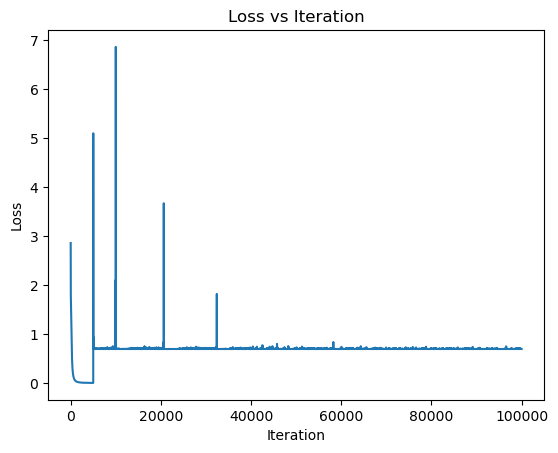

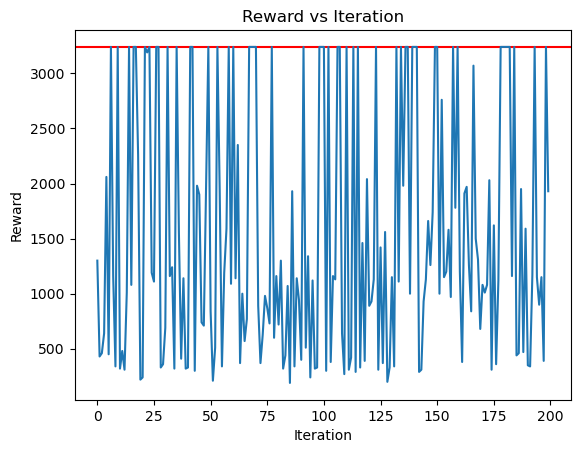

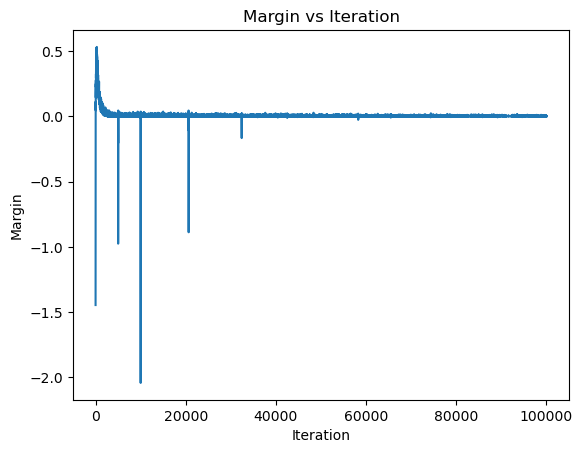

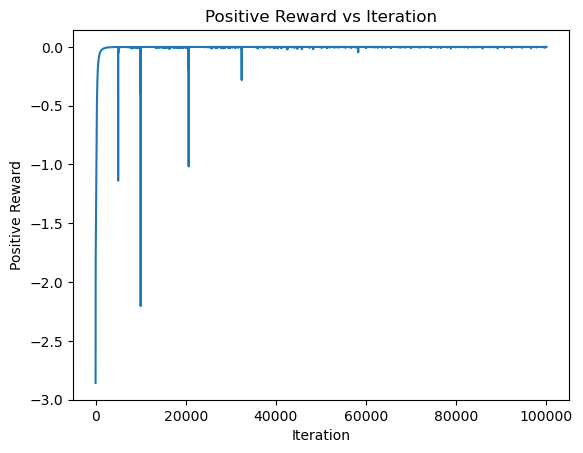

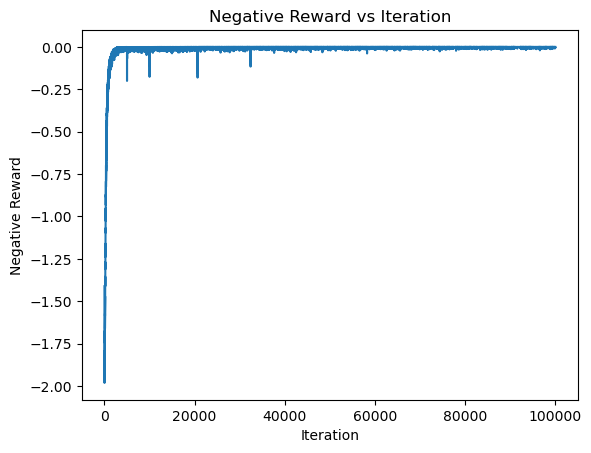

In [8]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
# draw a horizontal line at y=3240 which is the expert reward
plt.axhline(y=3240, color='r', linestyle='-', label="Expert Reward")
plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")

plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()


In [9]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/"+env_id+"_28000_rewards.png")
# plt.imshow(img)
# plt.show()